In [4]:
import pandas as pd
import numpy as np
import scipy as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import matplotlib as mpl
import matplotlib.pylab as plt

import seaborn as sns

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Table of Contents
>## 1. What is Recommender System?

>## 2. `Surprise` Package

>## 3. Sample Data
* 3.1. `MovieLens` - Movie Rating Dataset

>## 4. Similarities
* 4.1. Similarities in `surprise`
* 4.2. Mean Squared Difference Similarity
* 4.3. Cosine Similarity
* 4.4. Pearson Similarity
* 4.5. Pearson-Baseline Similarity

>## 5. Algorithms
* 5.1. Baseline Model
* 5.2. KNN-based Algorithms
* 5.3. Latent Factor Models

>## 6. Optimization Algorithms

>## 7. Performance Evaluation
* 7.1. How to Use Models
* 7.2. Performance Metric
* 7.3. `evaluate` Command

# 1. What is Recommender System?
> * **Input**: user id, item id 
> * **Output**: rating

# 2. `Surprise` Package
* Developed by Nicolas Hug [github](https://github.com/NicolasHug/Surprise) [doc](http://surprise.readthedocs.io/en/latest/index.html)
* Related Paper:
  * `Koren2010`: "Factor in the Neighbors: Scalable and Accurate Collaborative Filtering",  YEHUDA KOREN. 2010
    * http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf
  * `Koren2011`: "Collaborative Filtering on Ordinal User Feedback", Yehuda Koren and Joseph Sill, 2011
    * http://www.ijcai.org/Proceedings/13/Papers/449.pdf

In [5]:
import surprise

In [16]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# 3. Sample Data

## 3.1. `MovieLens` - Movie Rating Dataset

In [6]:
data = surprise.Dataset.load_builtin('ml-100k')

df = pd.DataFrame(data.raw_ratings, columns=["user", "item", "rate", "id"])
del df["id"]
df.head(5)

,user,item,rate
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


### from this, make `rate matrix`, $R$ (pivot table - $x$: item, $y$: user itd)

In [7]:
df_table = df.set_index(["user", "item"]).unstack()

df_table.iloc[212:222, 808:817].fillna("")

rate                                
item  211 212 213 214 215 216 217 218 219
user                                     
290     3                   4       2    
291         4       4   4           4   4
292                 3                    
293     4       3       4   4   3   2    
294                                      
295             5       5   5   4   5    
296     4                                
297     4       3       2   4       3    
298     5       3       5                
299     4   4   5           5

### we can visualizae this sparse matrix

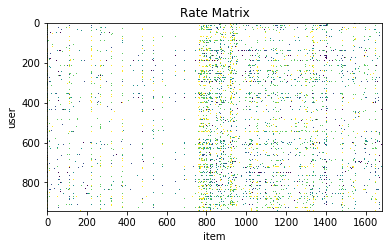

In [8]:
plt.imshow(df_table)
plt.grid(False)
plt.xlabel("item")
plt.ylabel("user")
plt.title("Rate Matrix")
plt.show()

# 4. Similarities

## 4.1. Similarities in `surprise`
* **Supported Similarities**:
  * Mean Squared Difference Similarity
  * Cosine Similarity
  * Pearson Similarity
  * Pearson-Baseline Similarity
* **Parameters**:
  * `name`: default=`'MSD'`.
  * `user_based`: if `False`, `item_based`
  * `min_support`: min. no. of shared ratings / if it's lower than this value, that vector is neglected
  * `shrinkage`: weight for shrinkage, default=`100`

## 4.2. Mean Squared Difference Similarity

* **MSD(Mean Squared Difference)**
  * **MSD** between user $u$ and $v$ ($|I_{uv}|$: no. of items that were rated both by $u$ and $v$)
  
>$$ \text{msd}(u, v) = \frac{1}{|I_{uv}|} \cdot \sum\limits_{i \in I_{uv}} (r_{ui} - r_{vi})^2 $$

  * **MSD** between items $i$ and $j$ ($|U_{ij}|$: no. of users that rated both $i$ and $j$)
  
>$$ \text{msd}(i, j) = \frac{1}{|U_{ij}|} \cdot \sum\limits_{u \in U_{ij}} (r_{ui} - r_{uj})^2 $$

* **MSD Similarity**
  * Inverse of MSD
  * add $1$ to prevent form being infinity

>$$ \begin{split}\text{msd_sim}(u, v) &= \frac{1}{\text{msd}(u, v) + 1}\\
\text{msd_sim}(i, j) &= \frac{1}{\text{msd}(i, j) + 1}\end{split} $$

## 4.3. Cosine Similarity

* **Cosine Similarity**

>$$ x \cdot y = |x| |y| \cos\theta $$

>$$ \cos\theta = \dfrac{x \cdot y}{|x| |y|}$$

* Cosine Similarity **between user $u$ and $v$**

>$$ \text{cosine_sim}(u, v) = \frac{
\sum\limits_{i \in I_{uv}} r_{ui} \cdot r_{vi}}
{\sqrt{\sum\limits_{i \in I_{uv}} r_{ui}^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} r_{vi}^2}
}$$


* Cosine Similarity **between item $i$ and $j$**

>$$ \text{cosine_sim}(i, j) = \frac{
\sum\limits_{u \in U_{ij}} r_{ui} \cdot r_{uj}}
{\sqrt{\sum\limits_{u \in U_{ij}} r_{ui}^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} r_{uj}^2}
} $$

## 4.4. Pearson Similarity

* **Pearson Similarity**: Pearson correlation coefficient between two vectors / **ranges from 0 to 1**

* Pearson Similarity **between user $u$ and $v$**

  * $\mu_u$: average rating from user $u$

>$$ \text{pearson_sim}(u, v) = \frac{
\sum\limits_{i \in I_{uv}} (r_{ui} -  \mu_u) \cdot (r_{vi} - \mu_{v})}
{\sqrt{\sum\limits_{i \in I_{uv}} (r_{ui} -  \mu_u)^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} (r_{vi} -  \mu_{v})^2}
} $$

* Pearson Similarity **between item $i$ and $j$**

  * $\mu_i$L: average rating for item $i$

>$$
\text{pearson_sim}(i, j) = \frac{
\sum\limits_{u \in U_{ij}} (r_{ui} -  \mu_i) \cdot (r_{uj} - \mu_{j})}
{\sqrt{\sum\limits_{u \in U_{ij}} (r_{ui} -  \mu_i)^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} (r_{uj} -  \mu_{j})^2}
}
$$

## 4.5. Pearson-Baseline Similarity

* Similar to Pearson similarity, but instead of average, use the prediction obtained from the baseline model

* Pearson-Baseline Similarity **between user $u$ and $v$**

>$$ \text{pearson_baseline_sim}(u, v) = \hat{\rho}_{uv} = \frac{
\sum\limits_{i \in I_{uv}} (r_{ui} -  b_{ui}) \cdot (r_{vi} - b_{vi})}
{\sqrt{\sum\limits_{i \in I_{uv}} (r_{ui} -  b_{ui})^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} (r_{vi} -  b_{vi})^2}} $$

* Pearson-Baseline Similarity **between item $i$ and $j$**

>$$\text{pearson_baseline_sim}(i, j) = \hat{\rho}_{ij} = \frac{
\sum\limits_{u \in U_{ij}} (r_{ui} -  b_{ui}) \cdot (r_{uj} - b_{uj})}
{\sqrt{\sum\limits_{u \in U_{ij}} (r_{ui} -  b_{ui})^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} (r_{uj} -  b_{uj})^2}}$$

* Pearson-Baseline **Shrunk** Similarity
  * Regularize with the no. of shared ratings (shrinkage)

>$$ \begin{split}\text{pearson_baseline_shrunk_sim}(u, v) &= \frac{|I_{uv}| - 1}
{|I_{uv}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{uv}\end{split} $$

>$$ \begin{split}\text{pearson_baseline_shrunk_sim}(i, j) &= \frac{|U_{ij}| - 1}
{|U_{ij}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{ij}\end{split} $$

# 5. Algorithms

* **Frequently Used Algorithms:**
  1. Baseline Model
  2. Collaborative Filtering
    * 2-1. Neighborhood Models
      * User-based CF
      * Item-based CF
    * 2-2. Latent Factor Models 
      * Matrix Factorization
      * SVD 
  3. Content-Based Recommendation

## 5.1. Baseline Model
* Simplest model - uses two categorical variables (user $u$ and item id $i$)

$$ \hat{r}_{ui} = \mu + b_u + b_i $$

* $\mu$: average rating
* $b_u$: bias for user
* $b_i$: bias for item

>#### Cost function:
$$ \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 $$

>#### Cost function (with regularization)
$$ \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 + \lambda \left(b_u^2 + b_i^2 \right) $$

## 5.2. KNN-based Algorithms

* Method:
  * 1. Selected $k$ users(items) with highest similarities
  * 2. Obtain **weighted average**

### `KNNBasic`
* Simple weighted average / $N^k$: set of $k$ vectors with highest similarities
* **USERS**
>$$  
\hat{r}_{ui} = \frac{
        \sum\limits_{v \in N^k_i(u)} \text{sim}(u, v) \cdot r_{vi}}
        {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} $$
        
* **ITEMS**

>$$
\hat{r}_{ui} = \frac{
        \sum\limits_{j \in N^k_u(i)} \text{sim}(i, j) \cdot r_{uj}}
        {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)}
$$

### `KNNWithMeans`
* Weighted average **around mean values**
* **USERS**

>$$  
\hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - \mu_v)} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)}
$$

* **ITEMS**

>$$
\hat{r}_{ui} = \mu_i + \frac{ \sum\limits_{j \in N^k_u(i)}
\text{sim}(i, j) \cdot (r_{uj} - \mu_j)} {\sum\limits_{j \in
N^k_u(i)} \text{sim}(i, j)}
$$

### `KNNBaseline`
* Weighted average **around baseline values**
* **USERS**

>$$  
\hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)}
$$

* **ITEMS**

>$$
\hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}
\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in
N^k_u(j)} \text{sim}(i, j)}
$$



### KNN-based Algorithms in `surprise`

In [17]:
sim_options = {'name': 'msd'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


{'fit_time': (0.323789119720459,
  0.28292298316955566,
  0.28261590003967285,
  0.29704809188842773,
  0.33688902854919434),
 'test_mae': array([0.77968809, 0.77318302, 0.76914665, 0.77689954, 0.76406517]),
 'test_rmse': array([0.98665443, 0.98010143, 0.9776492 , 0.98181878, 0.96428662]),
 'test_time': (2.438403844833374,
  2.527099132537842,
  2.7167551517486572,
  2.7209510803222656,
  3.068701982498169)}

In [10]:
sim_options = {'name': 'cosine'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([ 1.02165374,  1.01094947,  1.01980738,  1.01184665,  1.02300541]),
 'test_mae': array([ 0.80651253,  0.79884201,  0.80939573,  0.79869422,  0.80983937]),
 'fit_time': (1.303879737854004,
  1.323483943939209,
  1.3509433269500732,
  1.3605411052703857,
  1.395949125289917),
 'test_time': (3.7023730278015137,
  3.8315958976745605,
  4.047341346740723,
  3.92519211769104,
  3.9541914463043213)}

In [11]:
sim_options = {'name': 'pearson'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([ 1.01278354,  1.00450375,  1.0174979 ,  1.01443365,  1.01270663]),
 'test_mae': array([ 0.80344258,  0.79499421,  0.81000706,  0.80615134,  0.8017943 ]),
 'fit_time': (1.8531792163848877,
  1.846214771270752,
  1.9597270488739014,
  1.8481721878051758,
  2.1341586112976074),
 'test_time': (3.7127163410186768,
  3.9470386505126953,
  3.9085874557495117,
  7.5518574714660645,
  3.919593572616577)}

In [12]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([ 0.99420964,  0.99381429,  1.00551851,  1.00607764,  1.00277361]),
 'test_mae': array([ 0.78802934,  0.78557554,  0.79468128,  0.79776647,  0.79233398]),
 'fit_time': (1.795619010925293,
  2.116408109664917,
  2.273113250732422,
  2.5860753059387207,
  2.083158254623413),
 'test_time': (5.638208866119385,
  4.88642692565918,
  4.985062122344971,
  6.019118309020996,
  4.04525351524353)}

In [13]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNWithMeans(sim_options=sim_options)
cross_validate(algo, data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([ 0.93804715,  0.9416346 ,  0.93537587,  0.94230831,  0.92905337]),
 'test_mae': array([ 0.73170063,  0.73366927,  0.72843607,  0.73115355,  0.7247833 ]),
 'fit_time': (1.7749543190002441,
  2.5262176990509033,
  2.0504660606384277,
  2.4988651275634766,
  2.088900089263916),
 'test_time': (4.666452169418335,
  5.268358945846558,
  6.318281888961792,
  4.022022247314453,
  6.14544677734375)}

In [14]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNBaseline(sim_options=sim_options)
cross_validate(algo, data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([ 0.93960922,  0.92989621,  0.94359357,  0.93047967,  0.94191645]),
 'test_mae': array([ 0.73101426,  0.72355947,  0.73434632,  0.72678205,  0.73374179]),
 'fit_time': (2.359276533126831,
  2.7003281116485596,
  1.7818269729614258,
  1.783245325088501,
  1.8559072017669678),
 'test_time': (5.666726350784302,
  3.786963701248169,
  3.863645076751709,
  3.725850820541382,
  4.133976459503174)}

## 5.3. Latent Factor Models

* Dimensionality Reduction
* Tries to approximate the user(item) with several latent factors
* Example:
  * Movies $\rightarrow$ categorize into genres $\rightarrow$ create factor vector
  * **User A**: hates Action(-1), likes Comedy(+2), likes Drama(3)
>$$ p_u^T = (-1, 2, 3) $$  
  * **Movie A**: Action(+2), Comedy(+1), Drama(+3)
>$$ q_i^T = (2, 1, 1) $$
  * **Rating**:  
>$$ r_{ui} = q_i^Tp_u = -1 \cdot 2 + 2 \cdot 1 + 3 \cdot 1 = 3$$

### LFM - Matrix Factorization
* Tries to find $P$ and $Q$ in the folloing relation

>$$ R \approx PQ^T  $$
>* $R \in \mathbf{R}^{m \times n}$ : $m$ Users X $n$ Items
>* $P \in \mathbf{R}^{m \times k}$ : $m$ Users X $k$ Factors
>* $Q \in \mathbf{R}^{n \times k}$ : $n$ Items X $k$ Factors

### LFM - SVD (Singular Value Decomposition) 
* **Singular Value Decomposition**

>$$ R =  U \Sigma V^T $$
>* $U$: $m \times m$ / inverse is symmetric
>* $\Sigma$: $m \times n$ / non-diagonal components: 0
>* $V$: $n \times n$ / inverse is symmetric

* Diagonal of $\Sigma$: Singular Values
* Use the highest $k$ values, make **truncated SVD**

>* $\hat{U}$: $m \times k$ / $k$ components corresponding to $k$ values 
>* $\hat{\Sigma}$: $k \times k$ / diagonal 
>* $\hat{V}$: $k \times n$ / $k$ components corresponding to $k$ values
>$$ \hat{U} \hat{\Sigma} \hat{V}^T =  \hat{R} \approx R $$

* Yet, since the matrix is sparse, $P$ and $Q$ are obtained by minimizing the following error function

>$$ \hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u $$

>$$ \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $$

### Latent Factor Models in `surprise`
* `matrix_factorization` sub-package $\rightarrow$ `SVD` & `SVDpp`
* [for more info](http://surprise.readthedocs.io/en/latest/matrix_factorization.html)

In [15]:
algo = surprise.SVD(n_factors=200, n_epochs=30)
cross_validate(algo, data)

{'test_rmse': array([ 0.94552896,  0.94145917,  0.94533964,  0.94551113,  0.94411122]),
 'test_mae': array([ 0.74430468,  0.7412709 ,  0.74515731,  0.7434894 ,  0.74311073]),
 'fit_time': (12.17385196685791,
  12.747670412063599,
  12.985615491867065,
  13.0994393825531,
  13.013211011886597),
 'test_time': (0.28101205825805664,
  0.1651782989501953,
  0.28867030143737793,
  0.15938758850097656,
  0.28597450256347656)}

## 6. Optimization Algorithms
* Two optimization algorithms are available in `surprise`
* **SGD** (Stochastic Gradient Descent)
  * `reg`: regulation weight / default=0.02
  * `learning_rate`: optimization step-size / default=0.005
  * `n_epochs`: default=20
  
* **ALS** (Alternating Least Squares)
  * `reg_i`: regulatoin weight for items / default=10
  * `reg_u`: regulation weight for users / default=15
  * `n_epochs`: default=10

# 7. Performance Evaluation

## 7.1. How to Use Models

1. Use `split`, `folds` methods to make K-Fold training/test dataset
2. Create model algorithm object
3. Use `train` method to estimate the parameters
4. Use `test` method to predict test dataset
5. Use `accuracy` sub-package to evaluate its performance

* **OR** Simply use `evauate`

## 7.2. Performance Metrics
* `accuracy` sub-package
* **RMSE**(Root Mean Squared Error) - $\hat{R}$: test dataset

>$$ \text{RMSE} = \sqrt{\frac{1}{|\hat{R}|} \sum_{\hat{r}_{ui} \in \hat{R}}(r_{ui} - \hat{r}_{ui})^2} $$

* **MAE**(Mean Absolute Error)

>$$ \text{MAE} = \frac{1}{|\hat{R}|} \sum_{\hat{r}_{ui} \in \hat{R}}|r_{ui} - \hat{r}_{ui}| $$

* **FCP**(Fraction of Concordant Pairs)

>* Introduced in `Karen2011` / Instead of ratings themselves, compare their relative order

## 7.3. `evaluate` Command

#### Example - `BaselineOnly` Class & MovieLens data

In [7]:
from surprise.model_selection import KFold

bsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 12,
    'reg_i': 5
}
algo = surprise.BaselineOnly(bsl_options=bsl_options)

np.random.seed(0)
acc = np.zeros(3)
cv = KFold(3)
for i, (trainset, testset) in enumerate(cv.split(data)):
    algo.fit(trainset)
    predictions = algo.test(testset)
    acc[i] = surprise.accuracy.rmse(predictions, verbose=True)
acc.mean()

Estimating biases using als...
RMSE: 0.9453
Estimating biases using als...
RMSE: 0.9377
Estimating biases using als...
RMSE: 0.9500


0.94433049840139416

In [8]:
from surprise.model_selection import cross_validate

cross_validate(algo, data)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([ 0.9384446 ,  0.94651657,  0.93612815,  0.94221861,  0.94428787]),
 'test_mae': array([ 0.74477853,  0.75124267,  0.73975393,  0.745764  ,  0.74659098]),
 'fit_time': (0.23836255073547363,
  0.2933673858642578,
  0.31490063667297363,
  0.28768444061279297,
  0.2852976322174072),
 'test_time': (0.15769290924072266,
  0.28904008865356445,
  0.1457064151763916,
  0.2879183292388916,
  0.14188313484191895)}